In [1]:
import numpy as np

In [27]:
filename = 'demonstrations/energy_rudd_run002'
traj_data = np.load(filename+'.npz', allow_pickle=True)
print(np.shape(traj_data['actions']))

(3853, 3)


In [21]:
reset    = traj_data['episode_starts'][2:-1]
start    = traj_data['episode_starts'][1:-2]
done     = traj_data['episode_starts'][3:][np.all([~reset,~start], axis=0)]
obs      = np.copy(traj_data['obs'][1:-2][np.all([~reset,~start], axis=0)])
prev_obs = np.copy(traj_data['obs'][:-3][np.all([~reset,~start], axis=0)])
actions  = traj_data['actions'][1:-2][np.all([~reset,~start], axis=0)]
next_obs = np.copy(traj_data['obs'][2:-1][np.all([~reset,~start], axis=0)])
rewards  = traj_data['rewards'][1:-2][np.all([~reset,~start], axis=0)]
#rewards  = np.reshape(rewards, [rewards.shape[0], 1]) # create unused second dimension

delta = next_obs - obs
#crossings = np.abs(delta[:,2]) > 1 # yaw overflow
#delta[crossings,2] = -np.sign(delta[crossings,2])*(np.abs(delta[crossings,2]) - 2)
delta[:,2] = (delta[:,2] + 1) % 2 - 1
delta[:,4] = (delta[:,4] + 1) % 2 - 1

In [22]:
np.all([~reset,~start], axis=0)

array([False,  True,  True, ...,  True,  True,  True])

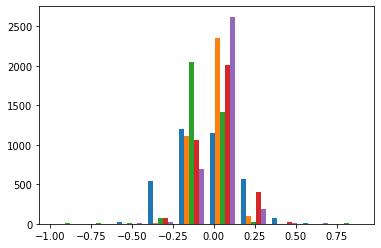

In [23]:
import matplotlib.pyplot as plt
plt.hist(delta)
plt.show()

In [24]:
obs_middle = np.array([15.0, 25.0, 0.0, 0.0, 0.0])
obs_radius = np.array([15.0, 25.0, np.pi, np.pi/2, np.pi])

prev_observation = prev_obs * obs_radius + obs_middle
observation      = obs * obs_radius + obs_middle
next_observation = next_obs * obs_radius + obs_middle
actions = np.hstack([actions, np.zeros_like(actions[:,:1])])


In [25]:
from scripts.get_model_dynamics import get_model_dynamics
dynamics  = get_model_dynamics(prev_observation, observation, actions)
pred_observation  = dynamics.get_pred_obs()
pred_rew  = dynamics.get_pred_rew()
pred_done = dynamics.get_pred_done()

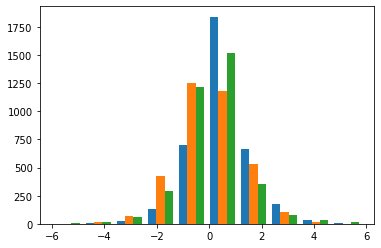

In [36]:
delta_pred = (pred_observation - observation)
delta_pred = np.hstack([delta_pred[:,:2], (delta_pred[:,2:5] + np.pi) % 2.0*np.pi - np.pi])

delta_true = (next_observation - observation)
delta_true = np.hstack([delta_true[:,:2], (delta_true[:,2:5] + np.pi) % 2.0*np.pi - np.pi])

plt.hist((delta_pred-delta_true)[:,2:])
plt.show()

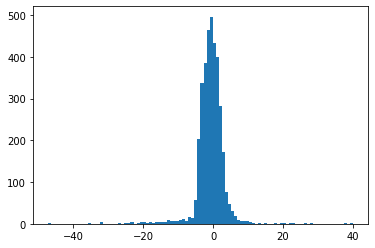

In [37]:
plt.hist((delta_pred)[:,0],100)
plt.show()

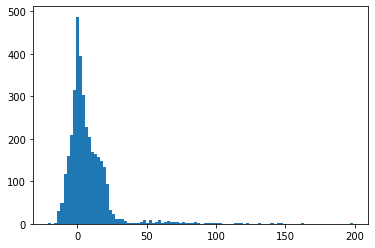

In [38]:
plt.hist((delta_pred-delta_true)[:,1], 100)
plt.show()